# PARTICLE IN A BOX

Time independent Schrodinger equation of infinite square well is:
\begin{equation*}
\left[ \frac{-\hbar^2}{2m} \frac{\mathrm{d}^2 }{\mathrm{d}x^2} + V(x) \right] \psi = E\psi
\end{equation*}
Where:
\begin{equation*}
V(x) = \begin{cases} 
0 & \text{if } 0 \leq x \leq 1 \\
\infty & \text{otherwise}
\end{cases}
\end{equation*}

Analtytic solutions of this problem:
\begin{equation*}    
\psi_n(x) = \begin{cases} 
\sqrt{2} \sin(n\pi x) & \text{if } 0 \leq x \leq 1 \\
0 & \text{otherwise}
\end{cases}
\end{equation*}

\begin{equation*} 
    E_{n} = \frac{n^2 \pi^2}{2} 
\end{equation*}

Where, $\hbar$ and $m$ set to 1 and n represents the energy states

## Loss Functions

* Schrodinger Loss  $\Longrightarrow \frac{1}{2} \frac{\mathrm{d}^2 }{\mathrm{d}x^2}\psi + E\psi$

* Normalization Loss $\Longrightarrow v(0) = 0, v(1) = 1$, where v = $\int_{0}^x |\psi(k)|^2 dk$

* Energy Loss $\Longrightarrow e^{-E+c}$


In [42]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import warnings

torch.set_default_device('cuda')
torch.set_default_dtype(torch.float32) 
warnings.filterwarnings("ignore")

In [43]:
# Analytical Solutions
def analytical_wavefunction(x, n):
    return np.sqrt(2) * np.sin(n * np.pi * x)

def analytical_energy(n):
    return (np.pi**2 * n**2) / 2

In [44]:
# Activation Function
class MySin(torch.nn.Module):
    @staticmethod
    def forward(input):
        return torch.sin(input)


In [45]:
# Neural Network Class
class NNs(nn.Module):
    
    def __init__(self):
        
        super(NNs, self).__init__()
        self.activation = MySin()
        self.input_En = nn.Linear(1, 1)
        self.hl1 = nn.Linear(2, 50)
        self.hl2 = nn.Linear(50, 50)
        self.output_layer = nn.Linear(50, 1)

    def forward(self, X):
        
        En_out = self.input_En(torch.ones_like(X)).cuda()
        hl1_outputs = self.activation(self.hl1(torch.cat((X, En_out), dim=1)))
        hl2_outputs = self.activation(self.hl2(hl1_outputs))
        output = self.output_layer(hl2_outputs)
        return output, En_out

    def wavefunction(self, x):
        
        x = torch.tensor(x, requires_grad=True).float().view(-1, 1)
        psi, _ = self.forward(x)
        wavefunction = (
            (1 - torch.exp(-1.0 * (x - 0))) *
            (1 - torch.exp(-1.0 * (1 - x))) *
            psi[:, 0:1]
        )
        return wavefunction

In [46]:
# Derivative Functions

def dfx(x,f):
    gopts = torch.ones(x.shape)
    return torch.autograd.grad([f], [x], grad_outputs=gopts, create_graph=True, retain_graph=True)[0]

def d2fx(x,f):
    gopts = torch.ones(x.shape)
    return torch.autograd.grad(dfx(x,f), [x], grad_outputs=gopts, create_graph=True, retain_graph=True)[0]

In [47]:
# Loss Functions

def wavefunction_loss(x, wavefunction, E_predicted):
    
    psi_d2x = d2fx(x, wavefunction)
    residue = (psi_d2x / 2 + E_predicted * wavefunction)
    return (residue.pow(2)).mean()


def normalization_loss(wavefunction):
    
        norm_loss =((-(torch.dot(wavefunction[:,0],wavefunction[:,0]))+200).pow(2))
        return norm_loss


In [48]:
class PINNs:
    
    def __init__(self, X, n=1):
        
        self.model = NNs()

        self.X = X.clone().detach().float().requires_grad_(True)
        self.test_x = np.linspace(0, 1, 200)

        lr=1e-3 
        betas = [0.999, 0.9999] 

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, betas=betas)
        self.Loss_history = []
        self.Phys_loss_history = []
        self.Norm_loss_history = []
        self.henryjin_parameter_history = []
        self.n = n
        self.E_true = analytical_energy(n)
        self.henryjin_parameter = -4
        
    def loss_henryjin(self, E_predicted):
        
        return torch.exp((-E_predicted + self.henryjin_parameter)).pow(2)

    def wavefunction_transform(self, x, wf):
        x = x.to('cuda')
        wf = wf.to('cuda')
        wf_out = (
            (1 - torch.exp(-1.0 * (x - 0))) *
            (1 - torch.exp(-1.0 * (1 - x))) *
            wf[:, 0:1]
        )
        
        return wf_out

    def last_wf_En(self, x):
        
        psi, En = self.model.forward(x)
        psi = self.wavefunction_transform(x, psi)
        return psi, En


    def train(self, epochs=45000):

        for epoch in range(epochs):
            
            wavefunction, En = self.last_wf_En(self.X)
            phys_loss = wavefunction_loss(self.X, wavefunction, En.mean())
            norm_loss = normalization_loss(wavefunction)
            henryjin_loss = self.loss_henryjin(En.mean())
            total_loss = phys_loss + norm_loss + henryjin_loss


            self.optimizer.zero_grad() 
            total_loss.backward() 
            self.optimizer.step()


            self.Loss_history.append(total_loss.item())
            self.Phys_loss_history.append(phys_loss.item())
            self.Norm_loss_history.append(norm_loss.item())

            self.henryjin_parameter_history.append(henryjin_loss.item())

            if epoch % 2500 == 0:
         
                self.henryjin_parameter += 1
              
            if epoch % 5000 == 0:
                
                print(f"Epoch {epoch}, Total Loss: {total_loss.item()}, Schrodinger Loss: {phys_loss.item()}, Norm Loss: {norm_loss.item()}, Energy: {En[0]}, Henryjin Loss: {henryjin_loss.item()}")
                plt.plot(self.test_x, self.evaluate(self.test_x)[0] )
                plt.xlabel("x")
                plt.ylabel("Wavefunction")
                plt.title("Wavefunction Over Epochs")
                plt.show()


    def evaluate(self,x_test_tensor):

        x_test = torch.FloatTensor(x_test_tensor).view(-1, 1).to('cuda')

        with torch.no_grad():
           
           psi, En = self.last_wf_En(x_test)
           psi = psi.cpu().numpy()
           En = En.cpu().numpy()
           
        return psi,En


    def plot_loss(self):
        
        plt.figure(figsize=(10, 6))
        plt.plot(self.Loss_history, label="Total Loss", linewidth=2)
        plt.plot(self.Phys_loss_history, label="Physics Loss", linestyle="--")
        plt.plot(self.Norm_loss_history, label="Normalization Loss", linestyle=":")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Loss Over Epochs")
        plt.grid(True)
        plt.show()

    def plot_PDE_loss(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.Phys_loss_history, label="Physics Loss")
        plt.xlabel("Epoch")
        plt.ylabel("PDE Loss")
        plt.legend()
        plt.title("PDE Loss Over Epochs")
        plt.grid(True)
        plt.show()

    def plot_Norm_loss(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.Norm_loss_history, label="Normalization Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Normalization Loss")
        plt.legend()
        plt.title("Normalization Loss Over Epochs")
        plt.grid(True)
        plt.show()

    def plot_henryjin_loss(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.henryjin_parameter_history, label="Henryjin Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Henryjin Loss")
        plt.legend()
        plt.title("Henryjin Loss Over Epochs")
        plt.grid(True)
        plt.show()

In [ ]:
X = torch.rand(200, 1)
pinns = PINNs(X)
pinns.train(epochs=400000)

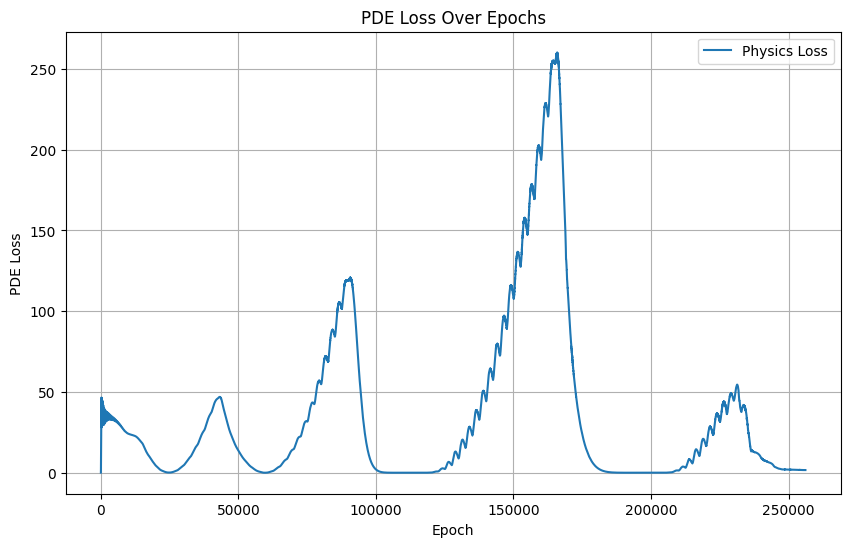

In [50]:
pinns.plot_PDE_loss()

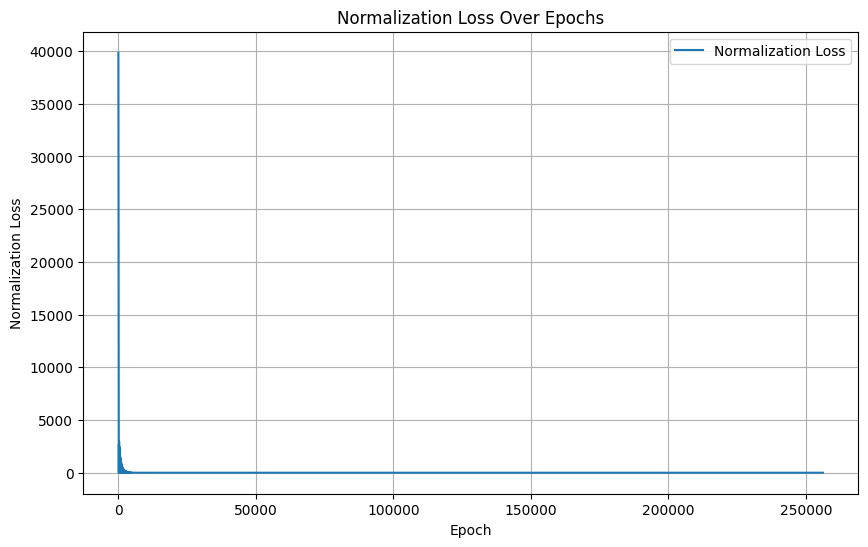

In [51]:
pinns.plot_Norm_loss()

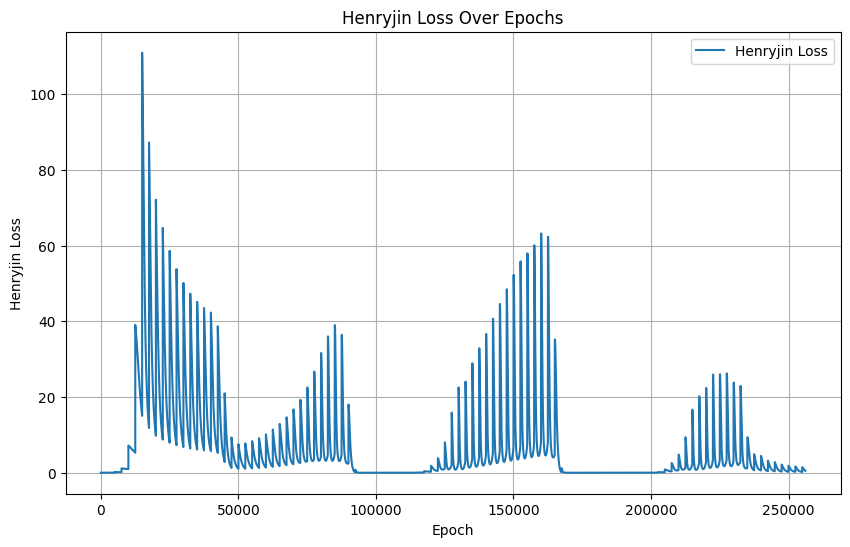

In [52]:
pinns.plot_henryjin_loss()